In [100]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import pandas as pd
import time
import numpy as np
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_selection import SelectFromModel
import keras 
from keras.models import Sequential
from keras.layers import Dense
import scipy.stats as stats
from scipy.stats import chi2_contingency
import warnings


In [202]:
house_df = pd.read_csv('data/house_mean_imputation.csv')
house_df = house_df.drop_duplicates(['year', 'state', 'district', 'name'])
display(house_df.shape)
display(house_df.head())

(9974, 20)

,district,is_incumbent,name,party,percent,state,votes,won,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
0,District 1,0.0,Ratliff Boon,D,42.1,Indiana,4281,1,1824,1824.0,0,5.790196,0.0,1.0,0,0.525667,200.179856,182.503597,D,552917.8375
1,District 1,1.0,Ratliff Boon,D,42.8,Indiana,5202,1,1826,1824.0,1,5.790196,0.0,1.0,0,0.525667,200.179856,182.503597,D,552917.8375
2,District 1,1.0,Ratliff Boon,D,52.2,Indiana,7272,1,1828,1824.0,2,5.790196,0.0,1.0,0,0.525667,200.179856,182.503597,D,552917.8375
3,District 1,0.0,John Law,D,49.1,Indiana,10868,0,1830,1860.0,0,5.790196,0.0,1.0,0,0.525667,200.179856,182.503597,D,552917.8375
4,District 1,1.0,Ratliff Boon,D,50.9,Indiana,11280,1,1830,1824.0,3,5.790196,0.0,1.0,0,0.525667,200.179856,182.503597,D,552917.8375


# Variable Selection

In [203]:
#these are the categrorical variables
cat_cols=['president_party','party','state','district','last_house_majority','name']
#These are the response variables
response_var = ['won', 'percent','votes']

In [236]:
#one-hot-coding is necessary because of category variables
#because it is no ordinary data we cannot do label encoding. So we do one-hot-encoding
def one_hot_coding(data,cat_cols,y_year=2018):
    #returns x and y variables for test and train
    
    #create dummy features
    data = pd.get_dummies(data, columns=cat_cols)
    
    #create data sets for test and training
    sel_train, sel_test=sel_df[sel_df['year']!=y_year], sel_df[sel_df['year']==y_year]
    
    x_train, y_train=sel_train.drop(columns = response_var, axis=1), sel_train['won']
    x_test, y_test=sel_test.drop(columns = response_var, axis=1), sel_test['won']
    
    return x_train, y_train, x_test, y_test

## Variable Selection - categorical variables

In [237]:
def chi2_test(x_col,y_col):
    x = x_col.astype(str)
    y= y_col.astype(str)

    obs_val = pd.crosstab(y,x)
    chi2, p, dof, expected = stats.chi2_contingency(obs_val.values)
    
    #dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    return chi2, p, dof

In [238]:
def print_chi2_result(data,y_col='won',cat_cols=cat_cols):
    for i in range(len(cat_cols)):
        chi2, p, dof = chi2_test(data[cat_cols[i]],data[y_col])
        if p>alpha:
            print('Important for the prediction model: {} (p-value: {:+.3f}, chi2: {:+.1f})'.format(cat_cols[i],p,chi2))
        else:
            print('\033[1mNOT\033[0m important for the prediction model: \033[1m{}\033[0m (p-value: {:+.3f}, chi2: {:+.1f})'.format(cat_cols[i],p,chi2))

In [239]:
print_chi2_result(house_df)

Important for the prediction model: president_party (p-value: +0.094, chi2: +4.7)
Important for the prediction model: party (p-value: +0.978, chi2: +0.0)
Important for the prediction model: state (p-value: +0.977, chi2: +31.3)
Important for the prediction model: district (p-value: +1.000, chi2: +8.4)
Important for the prediction model: last_house_majority (p-value: +0.661, chi2: +0.2)
NOT important for the prediction model: name (p-value: +0.000, chi2: +9241.0)


#### Interpretation: 
- Column "name" is not useful in the models

## Variable Selection - Random Forest with one-hot-coding 

In [240]:
#copy of original dataset
forest_df = house_df.copy()

#Exclude column name because of low p-value - see chapter "Variable Selection - categorical variables"
forest_df = forest_df.drop(columns = 'name')

#categorical columns for Random Forest model
forest_cat=['president_party','party','state','district','last_house_majority']

In [241]:
def var_sel_RF(forest_df,forest_cat=forest_cat,y_year=2018, threshold=0.003):
    #returns 1) sorted list of most important features
    #        2) Accuracy of model with all features and with selected features
    #thresold: minimum feature importance
    
    x_train, y_train, x_test, y_test = one_hot_coding(forest_df,forest_cat,y_year)
    
    # Create a random forest classifier. number of trees set to 1000
    clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    
    # Train the classifier
    clf.fit(x_train, y_train)
    feat_labels = x_train.columns
    feat_imp = []
    
    # name and gini importance of each feature
    for feature in zip(clf.feature_importances_,feat_labels):
        feat_imp.append(feature)
    feat_imp.sort(reverse=True)
    
    #list with most important features
    feat_imp = list(filter(lambda x: x[0] > threshold, feat_imp))
    
    # Create a selector object that will use the random forest classifier to identify
    # features that have an importance of more than 0.003
    sfm = SelectFromModel(clf, threshold=threshold)

    # Train the selector
    sfm.fit(x_train, y_train)
    
    # Transform the data to create a new dataset containing only the most important features
    # Note: We have to apply the transform to both the training X and test X data.
    X_important_train = sfm.transform(x_train)
    X_important_test = sfm.transform(x_test)
    
    # Create a new random forest classifier for the most important features
    clf_important = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

    # Train the new classifier on the new dataset containing the most important features
    clf_important.fit(X_important_train, y_train)
    
    # Accuracy of model with all features
    y_pred = clf.predict(x_test)
    print('Accuracy of model with all features: {}'.format(accuracy_score(y_test, y_pred)))
    
    # Accuracy of model with most important features
    y_important_pred = clf_important.predict(X_important_test)
    print('Accuracy of model with most important features: {}'.format(accuracy_score(y_test, y_important_pred)))
    
    return feat_imp

In [242]:
var_sel_RF(forest_df,forest_cat=forest_cat,y_year=2018, threshold=0.003)

Accuracy of model with all features: 0.969047619047619
Accuracy of model with most important features: 0.9702380952380952


[(0.4075507398881319, 'first_time_elected'),
 (0.19049897485117367, 'is_incumbent'),
 (0.10744801578798358, 'count_victories'),
 (0.03137329252168415, 'fundraising'),
 (0.012195163321721542, 'year'),
 (0.010041127139385968, 'unemployement_rate'),
 (0.0097777130325433, 'last_D_house_seats'),
 (0.009348505236896149, 'last_R_house_seats'),
 (0.006282731588713508, 'president_overall_avg_job_approval'),
 (0.004978813663712148, 'party_D'),
 (0.00495974751041747, 'party_R'),
 (0.003100478780759195, 'is_presidential_year')]

# Variable Selection - PCA      (not useful because of categorical variables)

In [249]:
#copy of original dataset
pca_df = house_df.copy()

#Exclude column name because of low p-value - see chapter "Variable Selection - categorical variables"
pca_df = pca_df.drop(columns = 'name')

#categorical columns for Random Forest model
pca_cat=['president_party','party','state','district','last_house_majority']

#columns to be deleted: respons variables and category variables
del_columns = ['won', 'percent','votes','president_party','party','state','district','last_house_majority']

In [250]:
#function return the pca object and the scaled dataframe used for PCA
def pca_with_scale(data,del_columns=del_columns,n_components=3000):
    #returns pca object and scaled dataframe
    #data: input dataframe
    #del_columns: array with columns to be deleted e.g. columns with strings cannot be used for pca analyzes
    
    #drop columns
    data = data.drop(columns = del_columns)
    
    scale_df = StandardScaler().fit_transform(data)
    scale_df = pd.DataFrame(data=scale_df,    # values
#              index=data[1:,0],    # 1st column as index
              columns=data.columns)  # 1st row as the column names
    scale_df = scale_df.dropna()
    pca = PCA(n_components = n_components).fit(scale_df)
    return pca, scale_df

In [251]:
#get data without category variables
x_train, y_train, x_test, y_test = one_hot_coding(pca_df,pca_cat,y_year=2018)

#get PCA object
pca, scale_df = pca_with_scale(pca_df,n_components=11)

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [252]:
print("Number of components that explain at least 90% of the variance=",\
    len(np.where(np.cumsum(pca.explained_variance_ratio_)<=0.9)[0])+1)

Number of components that explain at least 90% of the variance= 8


Text(0.5,1,'Cumulative variance explained')

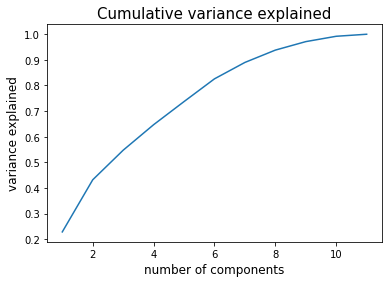

In [253]:
#Plot the variance, cumulated per component
plt.plot(np.linspace(1, 11, 11), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components', fontsize=12)
plt.ylabel('variance explained', fontsize=12)
plt.title('Cumulative variance explained',fontsize=15)

Text(0.5,1,'Variance explained by each component')

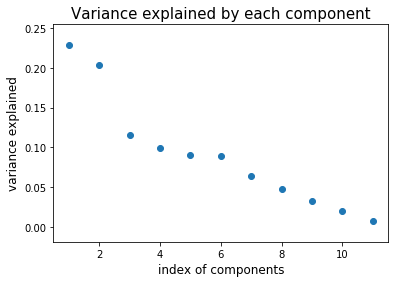

In [254]:
#Plot the variance for each component
plt.scatter(range(1, 11+1), pca.explained_variance_ratio_)
plt.xlabel('index of components', fontsize=12)
plt.ylabel('variance explained', fontsize=12)
plt.title('Variance explained by each component',fontsize=15)

# Final Conclusion
- Use all input variables beside "name"